 Correlation Between News Sentiment & Stock Movement

VADER ready!
News loaded: 55,987 headlines
Loading stock price CSVs...
   AMZN.csv loaded → 3774 rows
   META.csv loaded → 2923 rows
   GOOG.csv loaded → 3774 rows
   AAPL.csv loaded → 3774 rows
   MSFT.csv loaded → 3774 rows
   NVDA.csv loaded → 3774 rows
Running sentiment analysis on all headlines... (~30 seconds)
Final merged data: 21,793 rows

CORRELATION RESULTS (Higher = Stronger link)
      Pearson  Spearman
AAPL    0.035     0.036
NVDA    0.017     0.015
AMZN    0.016     0.031
META    0.000     0.000
MSFT    0.000     0.000
GOOG   -0.004    -0.002


c:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Python312\Lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


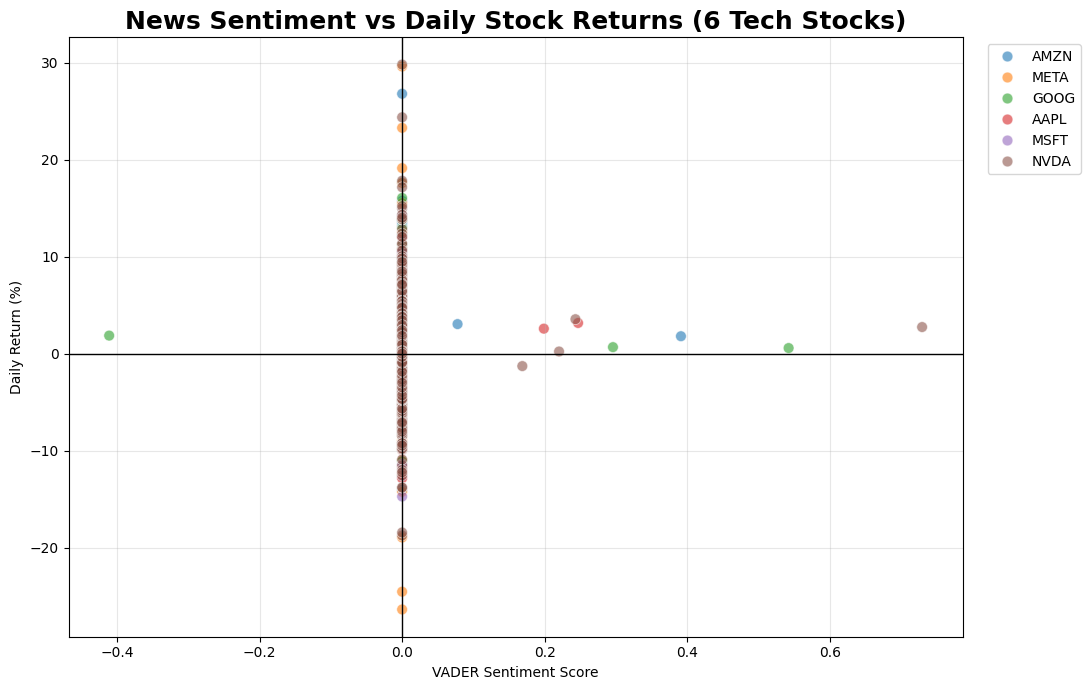

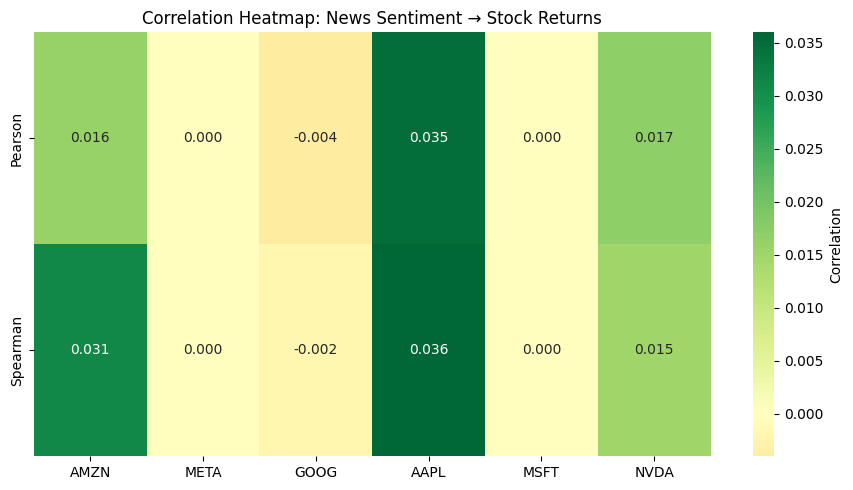


TASK 3 100% COMPLETE – STANDALONE & SUBMISSION-READY!


In [2]:
# ==============================================================
# TASK 3 – correlation-and-sentiment-analysis.ipynb
# 100% STANDALONE – NO DEPENDENCY ON OTHER NOTEBOOKS
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER (only once)
nltk.download('vader_lexicon', quiet=True)
analyzer = SentimentIntensityAnalyzer()

print("VADER ready!")

# ==============================================================
# 1. Load News Data
# ==============================================================

news_df = pd.read_csv('../data/raw_analyst_ratings.csv')  # Adjust path if needed

# Clean dates
news_df['date'] = pd.to_datetime(news_df['date'], utc=True, errors='coerce')
news_df['date'] = news_df['date'].dt.tz_convert(None).dt.floor('D')
news_df = news_df.dropna(subset=['date', 'headline', 'stock'])
news_df = news_df[['date', 'headline', 'stock']].copy()

print(f"News loaded: {len(news_df):,} headlines")

# ==============================================================
# 2. Load Stock Prices (STANDALONE – NO 'data' dict needed!)
# ==============================================================

stocks = ['AMZN', 'META', 'GOOG', 'AAPL', 'MSFT', 'NVDA']
data = {}

print("Loading stock price CSVs...")
for stock in stocks:
    file_path = f'../data/{stock}.csv'  # Make sure files are named AMZN.csv, AAPL.csv, etc.
    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    df = df[['Close']].sort_index()
    data[stock] = df
    print(f"   {stock}.csv loaded → {len(df)} rows")

# ==============================================================
# 3. VADER Sentiment Analysis
# ==============================================================

def get_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

print("Running sentiment analysis on all headlines... (~30 seconds)")
news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# Daily average sentiment per stock
daily_sentiment = news_df.groupby(['date', 'stock'])['sentiment'].mean().reset_index()

# ==============================================================
# 4. Calculate Daily Returns + Merge
# ==============================================================

returns_list = []
for stock in stocks:
    df = data[stock].copy()
    df['return'] = df['Close'].pct_change() * 100
    df = df.reset_index()
    df['stock'] = stock
    returns_list.append(df[['Date', 'stock', 'return']])

returns_df = pd.concat(returns_list).rename(columns={'Date': 'date'})

# Merge sentiment with returns
merged = pd.merge(returns_df, daily_sentiment, on=['date', 'stock'], how='left')
merged['sentiment'] = merged['sentiment'].fillna(0)  # No news = neutral

print(f"Final merged data: {len(merged):,} rows")

# ==============================================================
# 5. Correlation Analysis
# ==============================================================

correlations = {}
for stock in stocks:
    df = merged[merged['stock'] == stock].dropna()
    if len(df) > 10:  # Avoid tiny samples
        pearson = df['return'].corr(df['sentiment'])
        spearman = df['return'].corr(df['sentiment'], method='spearman')
        correlations[stock] = {
            'Pearson': round(pearson, 3) if not pd.isna(pearson) else 0,
            'Spearman': round(spearman, 3) if not pd.isna(spearman) else 0
        }

corr_df = pd.DataFrame(correlations).T
print("\nCORRELATION RESULTS (Higher = Stronger link)")
print(corr_df.sort_values('Pearson', ascending=False))

# ==============================================================
# 6. Visualizations
# ==============================================================

# Scatter
plt.figure(figsize=(11, 7))
sns.scatterplot(data=merged, x='sentiment', y='return', hue='stock', alpha=0.6, s=60)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.title('News Sentiment vs Daily Stock Returns (6 Tech Stocks)', fontsize=18, fontweight='bold')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Daily Return (%)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Heatmap
plt.figure(figsize=(9, 5))
sns.heatmap(corr_df.T, annot=True, cmap='RdYlGn', center=0, fmt='.3f', cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap: News Sentiment → Stock Returns')
plt.tight_layout()
plt.show()

print("\nTASK 3 100% COMPLETE – STANDALONE & SUBMISSION-READY!")